## GDAL

In [ ]:
from osgeo import gdal, gdalconst
import time

In [ ]:
driver = gdal.GetDriverByName('GTiff')
driver.Register()

In [ ]:
fn = '/data2/lthapa/FCCS_Fuel_Fire_Danger_Metric_LonLat.tif'
ds = gdal.Open(fn)

In [ ]:
cols = ds.RasterXSize
rows = ds.RasterYSize
bands = ds.RasterCount

print(cols,rows,bands) #shouldn't there be >1 band??

In [ ]:
geotransform = ds.GetGeoTransform()
originX = geotransform[0]
originY = geotransform[3]
pixelWidth = geotransform[1]
pixelHeight = geotransform[5]
print(geotransform)

In [ ]:
band = ds.GetRasterBand(1)

In [ ]:
startTime = time.time()
xValues = [-114]
yValues = [34]

for i in range(1):
    # get x,y
    x = xValues[i]
    y = yValues[i]
    # compute pixel offset
    xOffset = int((x - originX) / pixelWidth)
    yOffset = int((y - originY) / pixelHeight)
    
    s = str(x) + ' ' + str(y) + ' ' + str(xOffset) + ' ' + str(yOffset) + ' '
    
    for j in range(bands):
        band = ds.GetRasterBand(j+1) # 1-based index
        # read data and add the value to the string
        data = band.ReadAsArray(xOffset, yOffset, 20, 10)
        print(data)
        value = data[0,0]
        #s = s + str(value) + ' '
    # print out the data string
    print(s)
    
# figure out how long the script took to run
endTime = time.time()
print('The script took ' + str(endTime - startTime) + ' seconds')

## RASTERIO

In [1]:
import rasterio
from rasterio.windows import get_data_window,Window, from_bounds
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.enums import Resampling
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd

In [15]:
loadings = pd.read_csv('FWI_Category_Fuel_Loadings.csv').set_index('VALUE')
print(loadings)

       Unnamed: 0       COUNT  \
VALUE                           
-9999           0           0   
 0              1  1834822713   
 1              2    39788230   
 2              3    22214092   
 4              4    20963451   
...           ...         ...   
 1261         263   105438211   
 1273         264     7901952   
 1274         265    11911731   
 1281         266    91555820   
 1283         267   385671521   

                                              FUELBED_NA  Extreme_N  \
VALUE                                                                 
-9999                                             NoData   0.000000   
 0                                          Urban-Barren   0.000000   
 1     Black cottonwood-Douglas-fir-quaking aspen forest  42.912129   
 2     Western hemlock-western redcedar-Douglas-fir f...  58.860680   
 4                          Douglas-fir/ceanothus forest  24.196102   
...                                                  ...        ...   
 1

                           geometry
0  POINT (-1973638.681 1556273.103)
1  POINT (-1973069.841 1556713.789)
-1973638.6814353298 -1973069.8414401028 1556273.1025267234 1556713.7887778918
Window(col_off=12959.54395215567, row_off=54024.040374070275, width=18.96133317424392, height=14.689541705614829)
[[ 49  49  49  49  49  49  49  49   0  49   0   0   0  49  49  49   0  49]
 [ 49  49  49  49  49  49  49  49  49  49   0   0   0   0   0   0   0   0]
 [ 49   0   0   0  49  49  49  49  49   0   0  49  49  49  49  49  49  49]
 [ 49  49  49  49  49   0   0  49  49  49   0   0   0  49  49  49   0   0]
 [ 49  49  49  49   0   0   0   0   0  49  49   0   0   0  49  49  49  49]
 [ 49  49  49  49  49  49  49   0   0   0  49  49  49  49   0   0  49  49]
 [ 49  49  49  49  49  49  49  49  49   0   0   0   0   0  49  49  49   0]
 [ 49  49  49  49  49  49  49  49  49   0   0   0   0   0   0   0  49  49]
 [ 49  49  49   0  49  49  49  49  49  49  49  49  49   0   0   0   0  49]
 [ 49   0   0 311  49  49

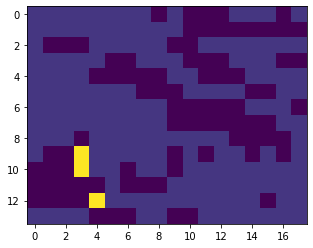

<AxesSubplot:>

In [7]:
p1 = Point(-118,35) #bottom left
p2 = Point(-117.995,35.005) #top right

d = {'geometry': [p1, p2]}
gdf = gpd.GeoDataFrame(d, crs=4326)
gdf= gdf.to_crs(5070)
print(gdf)

left = gdf.geometry[0].x
right = gdf.geometry[1].x
bottom = gdf.geometry[0].y
top = gdf.geometry[1].y
print(left,right,bottom,top)
with rasterio.open('../FCCS_Fuel_Fire_Danger_Metric.tif') as src:
    win = from_bounds(left,bottom,right,top, src.transform)
    print(win)
    w_from_latlon = src.read(1, window=win)
print(w_from_latlon)
show(w_from_latlon)

In [22]:
w_flat = w_from_latlon.flatten()
print(w_flat)
loading_new_extreme = loadings.loc[w_flat,'Extreme_N'].values.reshape(w_from_latlon.shape)
print(loading_new_extreme)

[ 49  49  49  49  49  49  49  49   0  49   0   0   0  49  49  49   0  49
  49  49  49  49  49  49  49  49  49  49   0   0   0   0   0   0   0   0
  49   0   0   0  49  49  49  49  49   0   0  49  49  49  49  49  49  49
  49  49  49  49  49   0   0  49  49  49   0   0   0  49  49  49   0   0
  49  49  49  49   0   0   0   0   0  49  49   0   0   0  49  49  49  49
  49  49  49  49  49  49  49   0   0   0  49  49  49  49   0   0  49  49
  49  49  49  49  49  49  49  49  49   0   0   0   0   0  49  49  49   0
  49  49  49  49  49  49  49  49  49   0   0   0   0   0   0   0  49  49
  49  49  49   0  49  49  49  49  49  49  49  49  49   0   0   0   0  49
  49   0   0 311  49  49  49  49  49   0  49   0  49  49   0  49   0  49
   0   0   0 311  49  49   0  49  49   0  49  49  49  49  49  49  49  49
   0   0   0   0   0  49   0   0   0  49  49  49  49  49  49  49  49  49
   0   0   0   0 311  49  49  49  49  49  49  49  49  49  49   0  49  49
  49  49  49  49   0   0   0  49  49   0   0  49  4

### Testing rasterio

In [ ]:
src = rasterio.open('../FCCS_Fuel_Fire_Danger_Metric.tif')

print(src.count) #number of bands/data layers
print(src.width)
print(src.height)
print(src.crs)

In [ ]:
w = src.read(1, window=Window(9000, 10000, 1000, 1000))
show(w)

In [ ]:
print(np.unique(w))

In [12]:
p1 = Point(-118,35) #bottom left
p2 = Point(-117.99,35.01) #top right

d = {'geometry': [p1, p2]}
gdf = gpd.GeoDataFrame(d, crs=4326)
gdf= gdf.to_crs(5070)
print(gdf)

left = gdf.geometry[0].x
right = gdf.geometry[1].x
bottom = gdf.geometry[0].y
top = gdf.geometry[1].y
print(left,right,bottom,top)

                           geometry
0  POINT (-1973638.681 1556273.103)
1  POINT (-1972501.053 1557154.514)
-1973638.6814353298 -1972501.0526358276 1556273.1025267234 1557154.5144406322


Window(col_off=12959.54395215567, row_off=54009.34951864559, width=37.92095998341392, height=29.38039713029866)


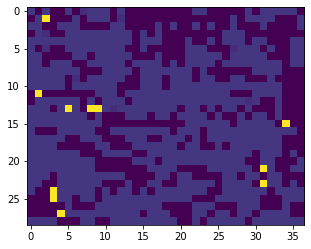

<AxesSubplot:>

In [13]:

with rasterio.open('../FCCS_Fuel_Fire_Danger_Metric.tif') as src:
    win = from_bounds(left,bottom,right,top, src.transform)
    print(win)
    w_from_latlon = src.read(1, window=win)
show(w_from_latlon)

In [11]:
rows = np.arange(win.row_off,win.row_off+win.height-1)
cols = np.arange(win.col_off,win.col_off+win.width-1)

COLS,ROWS=np.meshgrid(cols,rows)

xs, ys = rasterio.transform.xy(src.transform, ROWS, COLS)
print(np.array(xs))
print(np.array(ys))

[[-1973623.68143533 -1973593.68143533 -1973563.68143533 ...
  -1972603.68143533 -1972573.68143533 -1972543.68143533]
 [-1973623.68143533 -1973593.68143533 -1973563.68143533 ...
  -1972603.68143533 -1972573.68143533 -1972543.68143533]
 [-1973623.68143533 -1973593.68143533 -1973563.68143533 ...
  -1972603.68143533 -1972573.68143533 -1972543.68143533]
 ...
 [-1973623.68143533 -1973593.68143533 -1973563.68143533 ...
  -1972603.68143533 -1972573.68143533 -1972543.68143533]
 [-1973623.68143533 -1973593.68143533 -1973563.68143533 ...
  -1972603.68143533 -1972573.68143533 -1972543.68143533]
 [-1973623.68143533 -1973593.68143533 -1973563.68143533 ...
  -1972603.68143533 -1972573.68143533 -1972543.68143533]]
[[1557139.51444063 1557139.51444063 1557139.51444063 ... 1557139.51444063
  1557139.51444063 1557139.51444063]
 [1557109.51444063 1557109.51444063 1557109.51444063 ... 1557109.51444063
  1557109.51444063 1557109.51444063]
 [1557079.51444063 1557079.51444063 1557079.51444063 ... 1557079.51444

In [12]:
print(np.unique(w_from_latlon))
print(w_from_latlon.shape, np.array(xs).shape, np.array(ys).shape)

[  0  41  49 311]
(29, 37) (29, 37) (29, 37)


In [5]:
from dbfread import DBF

recs = []
count=0
for record in DBF('../FCCS_Fuel_Fire_Danger_Metric.tif.vat.dbf'):
    count = count+1
    recs.append(record)

In [7]:
loadings = pd.DataFrame(recs)
loadings.to_csv('FWI_Category_Fuel_Loadings.csv') #per FWI category per fuel bed loadings


In [ ]:
"""
DO NOT RUN THIS, TOO SLOW
# from https://gis.stackexchange.com/questions/388047/get-coordinates-of-all-pixels-in-a-raster-with-rasterio
file_name = '../FCCS_Fuel_Fire_Danger_Metric.tif'
with rasterio.open(file_name) as src:
    band1 = src.read(1)
    print('Band1 has shape', band1.shape)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    lons= np.array(xs)
    lats = np.array(ys)
    print('lons shape', lons.shape)"""